In [ ]:
#change the file paths here
path_train = "hw2_train.csv"
path_test = "hw2_test.csv"

#Importing Libs

In [ ]:
#importing all libs
import os
from typing import List
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import re
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, precision_recall_fscore_support, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#installing torchtext
!pip install torch
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.0 MB/s 
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which

In [ ]:
#device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#dropping all the data whose lengths of utterances and IOB slot tags are not matching 
df = pd.read_csv(path_train)
list_missmatch = []
for id in df['ID']:
  if len(str(df['UTTERANCES'][id]).split()) != len(str(df['IOB SLOT TAGS'][id]).split()):
    list_missmatch.append(id)
list_missmatch #dropping all the rows with unequal lengths

df.drop(list_missmatch, axis=0, inplace=True)

print(len(df))
df.head(5)

dict = {'ID': 'ID',
        'UTTERANCES': 'UTTERANCES',
        'IOB SLOT TAGS': 'IOB_SLOT_TAGS'}

df.rename(columns=dict,
          inplace=True) #renaming the columns 
df.head(5)


2253


,ID,UTTERANCES,IOB_SLOT_TAGS
0,0,who plays luke on star wars new hope,O O B_char O B_movie I_movie I_movie I_movie
1,1,show credits for the godfather,O O O B_movie I_movie
2,2,who was the main actor in the exorcist,O O O O O O B_movie I_movie
4,4,who played dory on finding nemo,O O B_char O B_movie I_movie
5,5,who was the female lead in resident evil,O O O O O O B_movie I_movie


In [ ]:
#creatingthe label dictionary
df["IOB_SLOT_TAGS"] = df["IOB_SLOT_TAGS"].str.replace("I-movie","I_movie") #replaced the irregular labels to regular ones

labels = df["IOB_SLOT_TAGS"].unique()

uniq_label = set()

for label in labels:
  if isinstance(label, str):
    label = str(label).split()
    [uniq_label.add(i) for i in label] #listing out all the unique labels

uniq_label = list(uniq_label)
print(len(uniq_label))
print(uniq_label)

print("{")

for i in range(len(uniq_label)):
  print('\t"'+uniq_label[i]+'" : ', i ," ,")

print("}")


26
['I_char', 'B_director', 'B_language', 'B_person', 'B_genre', 'B_location', 'B_producer', 'I_mpaa_rating', 'B_cast', 'I_director', 'I_cast', 'B_mpaa_rating', 'B_release_year', 'I_person', 'B_subject', 'B_movie', 'I_release_year', 'I_language', 'I_producer', 'I_genre', 'B_char', 'I_subject', 'B_country', 'I_movie', 'O', 'I_country']
{
	"I_char" :  0  ,
	"B_director" :  1  ,
	"B_language" :  2  ,
	"B_person" :  3  ,
	"B_genre" :  4  ,
	"B_location" :  5  ,
	"B_producer" :  6  ,
	"I_mpaa_rating" :  7  ,
	"B_cast" :  8  ,
	"I_director" :  9  ,
	"I_cast" :  10  ,
	"B_mpaa_rating" :  11  ,
	"B_release_year" :  12  ,
	"I_person" :  13  ,
	"B_subject" :  14  ,
	"B_movie" :  15  ,
	"I_release_year" :  16  ,
	"I_language" :  17  ,
	"I_producer" :  18  ,
	"I_genre" :  19  ,
	"B_char" :  20  ,
	"I_subject" :  21  ,
	"B_country" :  22  ,
	"I_movie" :  23  ,
	"O" :  24  ,
	"I_country" :  25  ,
}


In [ ]:
#defining the label dictionary
label_dict = {
                "B_language" :  0  ,
                "B_director" :  1  ,
                "I_country" :  2  ,
                "B_mpaa_rating" :  3  ,
                "I_release_year" :  4  ,
                "O" :  5  ,
                "B_producer" :  6  ,
                "B_genre" :  7  ,
                "I_language" :  8  ,
                "I_subject" :  9  ,
                "I_person" :  10  ,
                "B_subject" :  11  ,
                "B_release_year" :  12  ,
                "B_movie" :  13  ,
                "I_char" :  14  ,
                "I_movie" :  15  ,
                "B_cast" :  16  ,
                "I_director" :  17  ,
                "I_mpaa_rating" :  18  ,
                "B_country" :  19  ,
                "B_person" :  20  ,
                "B_char" :  21  ,
                "B_location" :  22  ,
                "I_genre" :  23  ,
                "I_cast" :  24  ,
                "I_producer" :  25  ,
              }


Counter({5: 10243, 15: 1094, 13: 981, 1: 180, 20: 177, 10: 166, 6: 164, 17: 163, 19: 153, 3: 140, 0: 119, 25: 114, 16: 105, 24: 104, 11: 95, 7: 71, 9: 33, 8: 17, 21: 15, 2: 12, 18: 12, 14: 5, 23: 5, 12: 4, 4: 3, 22: 2})
25
B_language count: 0
B_director count: 1
I_country count: 2
B_mpaa_rating count: 3
I_release_year count: 4
O count: 5
B_producer count: 6
B_genre count: 7
I_language count: 8
I_subject count: 9
I_person count: 10
B_subject count: 11
B_release_year count: 12
B_movie count: 13
I_char count: 14
I_movie count: 15
B_cast count: 16
I_director count: 17
I_mpaa_rating count: 18
B_country count: 19
B_person count: 20
B_char count: 21
B_location count: 22
I_genre count: 23
I_cast count: 24
I_producer count: 25


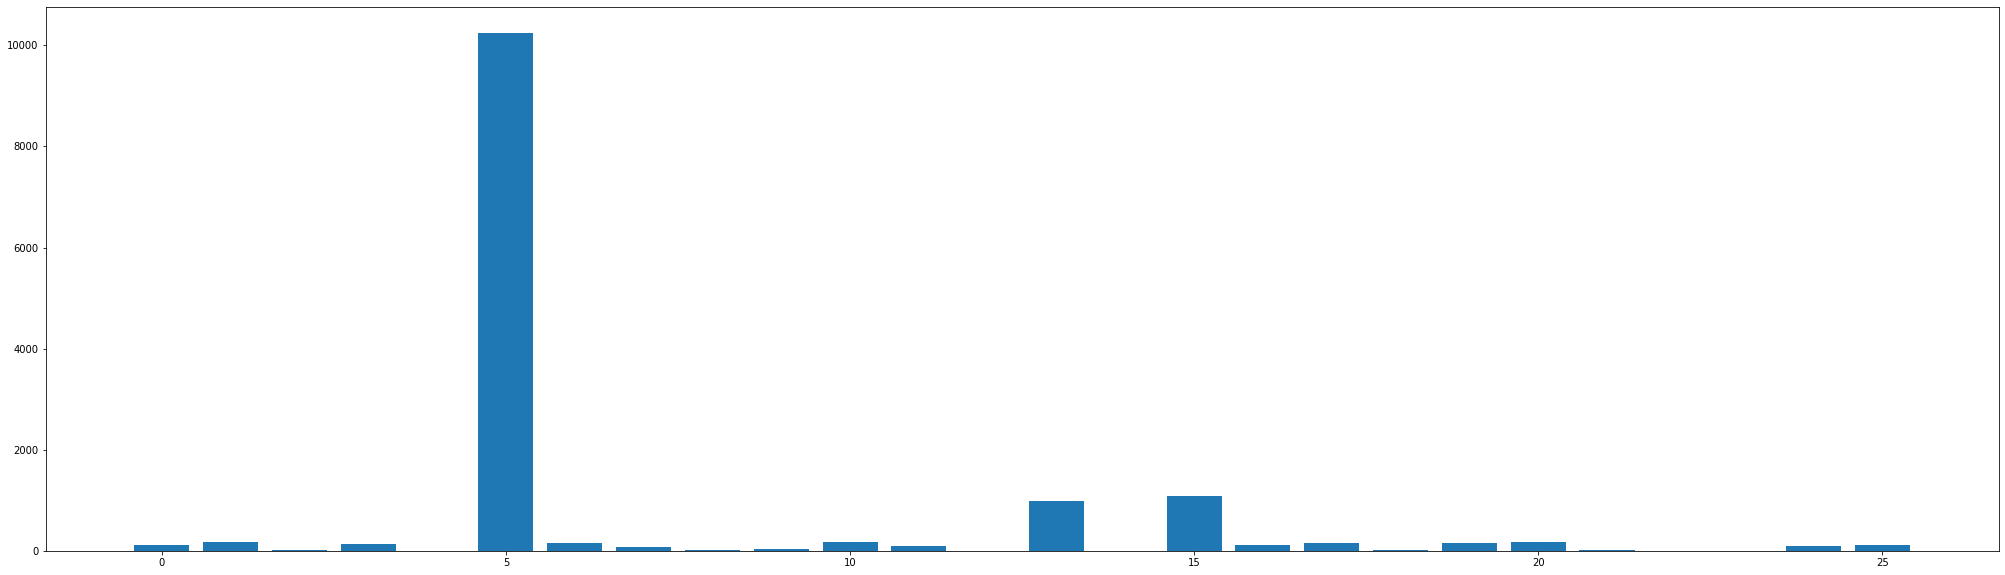

In [ ]:
#visualization for labels
df['IOB_label_list'] = df['IOB_SLOT_TAGS'].map(lambda x: [label_dict.get(a,-1) for a in str(x).split(" ")])

from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
all_label_keys = label_dict.keys()
all_labels = list(chain.from_iterable(df['IOB_label_list'].values))
c_val = Counter(all_labels)
print(c_val)
n_keys = c_val.keys()
max_idx = max(n_keys)
print(max_idx)
fig, ax1 = plt.subplots(1,1, figsize = (35, 10)) #for visulization of labels
ax1.bar(n_keys, [c_val[k] for k in n_keys])
for k,v in label_dict.items():
    print(k, 'count:', v)


In [ ]:
#creating the label vector
df['IOB_label_vec'] = df['IOB_label_list'].map(lambda ck: [int(i in ck) for i in range(max_idx+1)])
df.head(5)

df.to_csv('hw2_train_cleaned.csv')

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from collections import Counter

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
df = pd.read_csv('./hw2_train_cleaned.csv')
train_data, val_data = train_test_split(df, test_size=0.2) #splitting the data as 80:20
print(len(train_data), len(val_data))

1802 451


In [ ]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

In [ ]:
#tokenization of all UTTERANCES
vocab_size = 8_000
all_tokens = []
for review in tqdm(train_data['UTTERANCES']):
  tokens = tokenizer(review)
  # print(tokens)
  all_tokens.extend([i.text for i in tokens])

100%|██████████| 1802/1802 [00:00<00:00, 33410.26it/s]


In [ ]:
#creating the vocab
count = Counter(all_tokens)
tokens, counts = zip(*count.most_common(vocab_size))
vocab = {token: idx for idx, token in enumerate(tokens)} #creating a vocab dictionary
vocab['<unk>'] = len(vocab)
len(vocab)

1056

In [ ]:
#defining the label dictionary
label_dict = {
                "B_language" :  0  ,
                "B_director" :  1  ,
                "I_country" :  2  ,
                "B_mpaa_rating" :  3  ,
                "I_release_year" :  4  ,
                "O" :  5  ,
                "B_producer" :  6  ,
                "B_genre" :  7  ,
                "I_language" :  8  ,
                "I_subject" :  9  ,
                "I_person" :  10  ,
                "B_subject" :  11  ,
                "B_release_year" :  12  ,
                "B_movie" :  13  ,
                "I_char" :  14  ,
                "I_movie" :  15  ,
                "B_cast" :  16  ,
                "I_director" :  17  ,
                "I_mpaa_rating" :  18  ,
                "B_country" :  19  ,
                "B_person" :  20  ,
                "B_char" :  21  ,
                "B_location" :  22  ,
                "I_genre" :  23  ,
                "I_cast" :  24  ,
                "I_producer" :  25  ,
              }


In [ ]:
class UTTERDataset(Dataset):
  def __init__(self, data: pd.DataFrame, vocab):
    self.data = data
    self.vocab = vocab
    self.default = self.vocab['<unk>']

  def tokenize(self, text: str):
    return [i.text for i in tokenizer(text)]

  def encode_tokens(self, tokens):
    # print(tokens)
    encoded = [self.vocab.get(token, self.default) for token in tokens]
    return torch.tensor(encoded, device=device)

  def encode_label(self, label: str):
    # print(label)
    # label_token = [label_dict[k] for k in label.split()]
    # encoded=[]
    # for k in label_token:
    #   enc = [0 for i in range(n_label)]
    #   enc[k] = 1
    #   encoded.append(enc)
    encoded = [label_dict[k] for k in label.split()]
    return torch.tensor(encoded, device=device ,dtype=torch.long)
  
  def __getitem__(self, n: int):
    utt = self.data['UTTERANCES'].iloc[n]
    iob_slot = self.data['IOB_SLOT_TAGS'].iloc[n]
    return self.encode_tokens(self.tokenize(utt)), self.encode_label(iob_slot)

  def __len__(self):
    return len(self.data)

In [ ]:
train_ds = UTTERDataset(train_data, vocab)
val_ds = UTTERDataset(val_data, vocab)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#defining the model

class TagRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_classes):
        super(TagRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_classes = n_classes
        self.batch_size = 1
        self.embedding = nn.Embedding(self.vocab_size, self.hidden_size) #embedding layer
        self.dropout = nn.Dropout(p=0.2)

        self.rnn = nn.GRU(self.hidden_size, hidden_size=self.hidden_size,
                          bidirectional=False,
                          num_layers=2, batch_first=True) #Applying a multi-layer gated recurrent unit (GRU) RNN to an input sequence.

        self.linear = nn.Linear(hidden_size, n_classes) #output layer

    def forward(self, input):
        input_embedding = self.embedding(input)
        rnn_out, _ = self.rnn(input_embedding, None)
        # print(rnn_out.shape)
        affine_out = self.linear(torch.squeeze(rnn_out, 0)) #affine transformation
        # affine_out = self.linear(rnn_out)

        return F.log_softmax(affine_out)


In [ ]:
!pip -q install torchsummary
from torchsummary import summary
#Hyper meters
hidden_size = 256
n_epochs = 20
learning_rate = 0.05
embedding_size = 256
n_label = 26

model = TagRNN(vocab_size, hidden_size, n_label)
model.cuda() #-> model to devise

TagRNN(
  (embedding): Embedding(8000, 256)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): GRU(256, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=26, bias=True)
)

In [ ]:
# !git clone https://github.com/chakki-works/seqeval
# from seqeval.metrics import accuracy_score
# from seqeval.metrics import classification_report
# from seqeval.metrics import f1_score

In [ ]:
def train(loader, model, optimizer, loss_fn):
  model.train()
  losses = []
  pbar = tqdm(loader)
  for x, y in pbar:
    optimizer.zero_grad()

    # run the model on the input
    logits = model(x)
    y = torch.squeeze(y,0)
    # logits = torch.squeeze(logits,0)
    # logits = logits.unsqueeze(0)
    # logits_ = logits.reshape(-1)
    # y_ = y.reshape(-1)
    # print(logits.shape, y.shape)
    loss = loss_fn(logits, y)
    #acc = accuracy(logits, y)
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())

    loss.backward()  # calculate gradients for w/b
    optimizer.step()  # update weights according to optimizer rules
  return sum(losses) / len(losses), 


def evaluate(loader, model, loss_fn):
  model.eval()
  predictions = []
  labels = []
  for x, y in tqdm(loader):
    logits = model(x)
    y = torch.squeeze(y,0)
    # print(logits.shape, y.shape)
    # logits_ = logits.reshape(-1)
    # y_ = y.reshape(-1)
    # loss = loss_fn(logits_, y_)

    pred = torch.argmax(logits, dim=-1)
    # # gt = torch.argmax(y, dim=-1)
    # # print(pred.shape, gt.shape)
    predictions.append(pred.detach().cpu().numpy())
    labels.append(y.detach().cpu().numpy())
  score = score_fn(labels, predictions)
  return score

def score_fn(a, b):
  sum = 0
  count = 0
  # print(a)
  # print(b)
  for i in range(len(a)):
    sum += np.sum(a[i]==b[i])
    count += a[i].shape[-1]
  print(sum,count)
  return sum/count

In [ ]:
import matplotlib.pyplot as plt
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
loss_fn = nn.CrossEntropyLoss()#nn.NLLLoss()
# score_fn = accuracy_score
accuracy_list = []
avg_loss_list = []
n_epochs = 30
best_acc = 0
for epoch in range(n_epochs):
  avg_loss = train(train_loader, model, optimizer, loss_fn)
  avg_loss_list.append(avg_loss)
  print('train loss: ', avg_loss)

  scheduler.step()

  accuracy = evaluate(val_loader, model, loss_fn)
  accuracy_list.append(accuracy)
  print('val accuracy: ', accuracy)
  if accuracy > best_acc and accuracy > 0.7:
    torch.save(model.state_dict(), f'best-model.pt')



100%|██████████| 1802/1802 [00:18<00:00, 98.01it/s, loss=1.39] 


train loss:  (1.251663818020998,)


100%|██████████| 451/451 [00:00<00:00, 1031.23it/s]


2209 2819
val accuracy:  0.7836112096488116


100%|██████████| 1802/1802 [00:11<00:00, 162.14it/s, loss=0.81]


train loss:  (0.7485711054941567,)


100%|██████████| 451/451 [00:00<00:00, 1005.67it/s]


2379 2819
val accuracy:  0.8439162823696347


100%|██████████| 1802/1802 [00:12<00:00, 147.07it/s, loss=0.118]


train loss:  (0.5643287935140713,)


100%|██████████| 451/451 [00:00<00:00, 1028.22it/s]


2450 2819
val accuracy:  0.8691025186236254


100%|██████████| 1802/1802 [00:10<00:00, 165.87it/s, loss=0.223]


train loss:  (0.4302248986600459,)


100%|██████████| 451/451 [00:00<00:00, 1047.65it/s]


2513 2819
val accuracy:  0.8914508691025186


100%|██████████| 1802/1802 [00:10<00:00, 165.29it/s, loss=0.213]


train loss:  (0.3356831060823833,)


100%|██████████| 451/451 [00:00<00:00, 1081.31it/s]


2553 2819
val accuracy:  0.9056402979780064


100%|██████████| 1802/1802 [00:10<00:00, 166.01it/s, loss=0.738]


train loss:  (0.2689369277731335,)


100%|██████████| 451/451 [00:00<00:00, 1082.88it/s]


2565 2819
val accuracy:  0.9098971266406527


100%|██████████| 1802/1802 [00:10<00:00, 164.19it/s, loss=0.0058]


train loss:  (0.221769960286827,)


100%|██████████| 451/451 [00:00<00:00, 1051.56it/s]


2601 2819
val accuracy:  0.9226676126285916


100%|██████████| 1802/1802 [00:12<00:00, 142.21it/s, loss=0.0303]


train loss:  (0.1843144188106644,)


100%|██████████| 451/451 [00:00<00:00, 1044.69it/s]


2591 2819
val accuracy:  0.9191202554097198


100%|██████████| 1802/1802 [00:11<00:00, 162.61it/s, loss=0.0335]


train loss:  (0.15569716176002873,)


100%|██████████| 451/451 [00:00<00:00, 1008.60it/s]


2594 2819
val accuracy:  0.9201844625753813


100%|██████████| 1802/1802 [00:11<00:00, 162.46it/s, loss=0.00765]


train loss:  (0.1348396543872109,)


100%|██████████| 451/451 [00:00<00:00, 1048.50it/s]


2600 2819
val accuracy:  0.9223128769067045


100%|██████████| 1802/1802 [00:10<00:00, 164.14it/s, loss=0.128]


train loss:  (0.11235092336494731,)


100%|██████████| 451/451 [00:00<00:00, 1032.93it/s]


2616 2819
val accuracy:  0.9279886484568997


100%|██████████| 1802/1802 [00:11<00:00, 161.23it/s, loss=0.0114]


train loss:  (0.10881206152298263,)


100%|██████████| 451/451 [00:00<00:00, 1036.35it/s]


2614 2819
val accuracy:  0.9272791770131252


100%|██████████| 1802/1802 [00:11<00:00, 162.05it/s, loss=0.275]


train loss:  (0.10645252340295212,)


100%|██████████| 451/451 [00:00<00:00, 1079.54it/s]


2615 2819
val accuracy:  0.9276339127350124


100%|██████████| 1802/1802 [00:11<00:00, 163.04it/s, loss=0.0518]


train loss:  (0.10461347776977573,)


100%|██████████| 451/451 [00:00<00:00, 1039.26it/s]


2615 2819
val accuracy:  0.9276339127350124


100%|██████████| 1802/1802 [00:11<00:00, 161.89it/s, loss=0.0434]


train loss:  (0.10286912613489375,)


100%|██████████| 451/451 [00:00<00:00, 1057.64it/s]


2613 2819
val accuracy:  0.9269244412912381


100%|██████████| 1802/1802 [00:10<00:00, 165.24it/s, loss=0.123]


train loss:  (0.10081570603310173,)


100%|██████████| 451/451 [00:00<00:00, 962.12it/s] 


2616 2819
val accuracy:  0.9279886484568997


100%|██████████| 1802/1802 [00:11<00:00, 159.82it/s, loss=0.00428]


train loss:  (0.10059811235199319,)


100%|██████████| 451/451 [00:00<00:00, 1107.11it/s]


2617 2819
val accuracy:  0.9283433841787868


100%|██████████| 1802/1802 [00:11<00:00, 161.39it/s, loss=0.0038]


train loss:  (0.10043121196054294,)


100%|██████████| 451/451 [00:00<00:00, 1048.65it/s]


2619 2819
val accuracy:  0.9290528556225612


100%|██████████| 1802/1802 [00:11<00:00, 160.10it/s, loss=0.0475]


train loss:  (0.10027507647493589,)


100%|██████████| 451/451 [00:00<00:00, 1050.68it/s]


2618 2819
val accuracy:  0.928698119900674


100%|██████████| 1802/1802 [00:11<00:00, 159.86it/s, loss=0.00241]


train loss:  (0.1001260023948323,)


100%|██████████| 451/451 [00:00<00:00, 1055.42it/s]


2618 2819
val accuracy:  0.928698119900674


100%|██████████| 1802/1802 [00:11<00:00, 160.73it/s, loss=0.00257]


train loss:  (0.0999788916674389,)


100%|██████████| 451/451 [00:00<00:00, 1046.26it/s]


2617 2819
val accuracy:  0.9283433841787868


100%|██████████| 1802/1802 [00:11<00:00, 158.22it/s, loss=0.0101]


train loss:  (0.09983242905877963,)


100%|██████████| 451/451 [00:00<00:00, 1047.30it/s]


2616 2819
val accuracy:  0.9279886484568997


100%|██████████| 1802/1802 [00:11<00:00, 162.20it/s, loss=0.155]


train loss:  (0.09968743998429197,)


100%|██████████| 451/451 [00:00<00:00, 754.20it/s]


2616 2819
val accuracy:  0.9279886484568997


100%|██████████| 1802/1802 [00:11<00:00, 158.36it/s, loss=0.0724]


train loss:  (0.0995430428091581,)


100%|██████████| 451/451 [00:00<00:00, 1032.11it/s]


2617 2819
val accuracy:  0.9283433841787868


100%|██████████| 1802/1802 [00:11<00:00, 158.36it/s, loss=0.00235]


train loss:  (0.09939947840947137,)


100%|██████████| 451/451 [00:00<00:00, 1029.08it/s]


2618 2819
val accuracy:  0.928698119900674


100%|██████████| 1802/1802 [00:11<00:00, 157.82it/s, loss=0.00212]


train loss:  (0.09925483948025472,)


100%|██████████| 451/451 [00:00<00:00, 1026.05it/s]


2616 2819
val accuracy:  0.9279886484568997


100%|██████████| 1802/1802 [00:11<00:00, 158.85it/s, loss=0.0282]


train loss:  (0.09911298271844872,)


100%|██████████| 451/451 [00:00<00:00, 1070.36it/s]


2616 2819
val accuracy:  0.9279886484568997


100%|██████████| 1802/1802 [00:11<00:00, 159.37it/s, loss=0.0102]


train loss:  (0.09897226017369652,)


100%|██████████| 451/451 [00:00<00:00, 1025.17it/s]


2616 2819
val accuracy:  0.9279886484568997


100%|██████████| 1802/1802 [00:11<00:00, 158.06it/s, loss=0.137]


train loss:  (0.098831799058343,)


100%|██████████| 451/451 [00:00<00:00, 1055.07it/s]


2616 2819
val accuracy:  0.9279886484568997


100%|██████████| 1802/1802 [00:11<00:00, 157.40it/s, loss=1.2]


train loss:  (0.09869072672217277,)


100%|██████████| 451/451 [00:00<00:00, 1050.79it/s]

2618 2819
val accuracy:  0.928698119900674


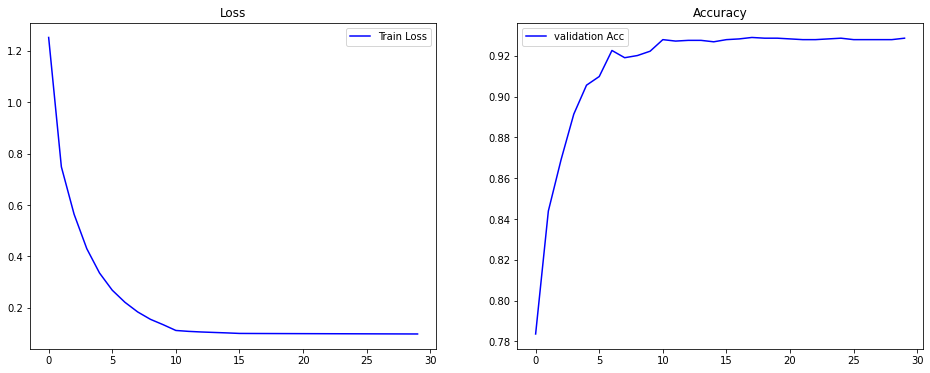

In [ ]:
#with SGD, I guess model was overfitting... :(
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# Plot loss values over the epochs
ax1 = ax[0]
ax1.set_title("Loss")
ax1.plot(avg_loss_list, color="blue", label="Train Loss")
ax1.legend()

# # Plot accuracies over the epochs
ax2 = ax[1]
ax2.set_title("Accuracy")
ax2.plot(accuracy_list, color="blue", label="validation Acc")
ax2.legend()

plt.show()

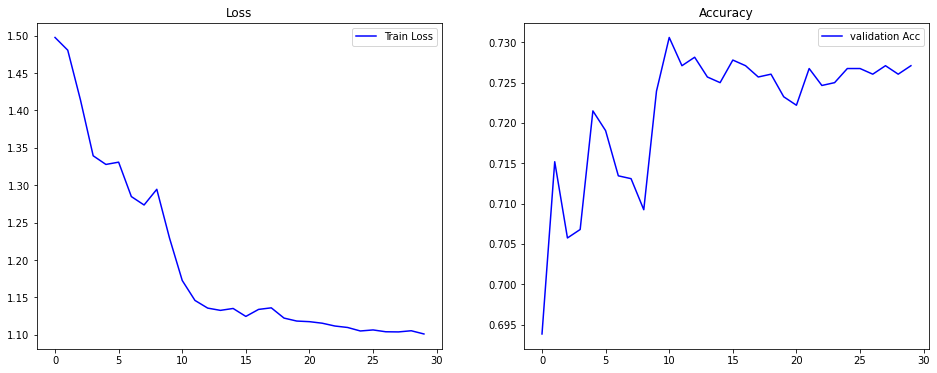

In [ ]:
#with LR scheduler
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# Plot loss values over the epochs
ax1 = ax[0]
ax1.set_title("Loss")
ax1.plot(avg_loss_list, color="blue", label="Train Loss")
ax1.legend()

# # Plot accuracies over the epochs
ax2 = ax[1]
ax2.set_title("Accuracy")
ax2.plot(accuracy_list, color="blue", label="validation Acc")
ax2.legend()

plt.show()

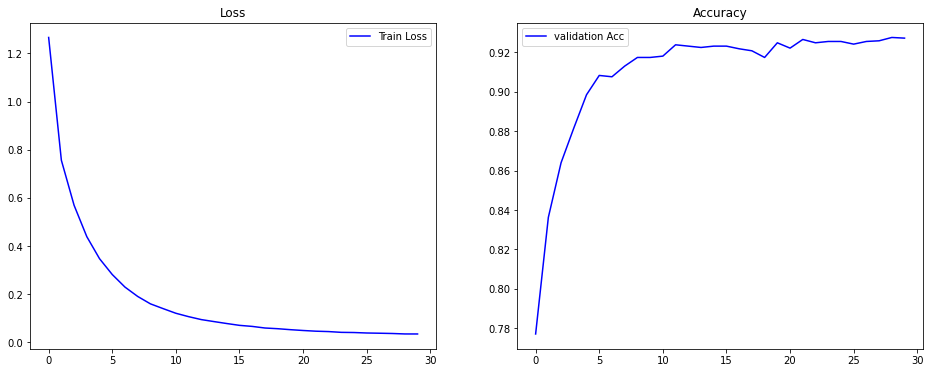

In [ ]:
#with learning rate 0.05 -> Model was overfitting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# Plot loss values over the epochs
ax1 = ax[0]
ax1.set_title("Loss")
ax1.plot(avg_loss_list, color="blue", label="Train Loss")
ax1.legend()

# # Plot accuracies over the epochs
ax2 = ax[1]
ax2.set_title("Accuracy")
ax2.plot(accuracy_list, color="blue", label="validation Acc")
ax2.legend()

plt.show()

In [ ]:
label_dicts = {
              0:"B_language",
              1:"B_director",
              2:"I_country" ,
              3:"B_mpaa_rating" ,
              4:"I_release_year" ,
              5:"O" ,
              6:"B_producer" ,
              7:"B_genre" ,
              8:"I_language" ,
              9:"I_subject" ,
              10:"I_person" ,
              11:"B_subject" ,
              12:"B_release_year" ,
              13:"B_movie" ,
              14:"I_char" ,
              15:"I_movie" ,
              16:"B_cast" ,
              17:"I_director" ,
              18:"I_mpaa_rating" ,
              19:"B_country" ,
              20:"B_person" ,
              21:"B_char" ,
              22:"B_location" ,
              23:"I_genre" ,
              24:"I_cast" ,
              25:"I_producer" ,
              }

In [ ]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

def predict_relations(model, vocab, sentence):
    model.eval()

    tokenized = [i.text for i in tokenizer(sentence)]
    encoded = [vocab.get(token, vocab['<unk>']) for token in tokenized]
    tensor = torch.LongTensor(encoded).to(device)
    tensor = tensor.unsqueeze(0)
    pred = model(tensor)
    prediction = torch.argmax(pred, dim=-1)
    print(tensor.shape)
    # prediction = torch.round(pred).int().squeeze()
    # print((prediction==1).nonzero(as_tuple=True))
    pred_strings = [label_dicts.get(i.item()) for i in prediction]
    return pred_strings
    

In [ ]:
predict_relations(model, vocab, "who was in twilight")

torch.Size([1, 4])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


['O', 'O', 'O', 'B_movie']

In [ ]:
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [ ]:
test_df = pd.read_csv('hw2_test.csv')
test_df.head()

,ID,UTTERANCES
0,0,star of thor
1,1,who is in the movie the campaign
2,2,list the cast of the movie the campaign
3,3,who was in twilight
4,4,who is in vulguria


In [ ]:
for i, row in test_df.iterrows():
  predictions = predict_relations(model, vocab, test_df.at[i,'UTTERANCES'])
  relations = ""
  for pred in predictions:
    relations += pred + " "
    
  test_df.at[i,'IOB Slot tags'] = relations

test_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 3])
torch.Size([1, 7])
torch.Size([1, 8])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 3])
torch.Size([1, 6])
torch.Size([1, 7])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 5])
torch.Size([1, 6])
torch.Size([1, 11])
torch.Size([1, 16])
torch.Size([1, 5])
torch.Size([1, 4])
torch.Size([1, 3])
torch.Size([1, 7])
torch.Size([1, 3])
torch.Size([1, 8])
torch.Size([1, 4])
torch.Size([1, 7])
torch.Size([1, 5])
torch.Size([1, 4])
torch.Size([1, 7])
torch.Size([1, 3])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 9])
torch.Size([1, 9])
torch.Size([1, 7])
torch.Size([1, 9])
torch.Size([1, 10])
torch.Size([1, 9])
torch.Size([1, 4])
torch.Size([1, 7])
torch.Size([1, 3])
torch.Size([1, 8])
torch.Size([1, 5])
torch.Size([1, 8])
torch.Size([1, 5])
torch.Size([1, 10])
torch.Size([1, 9])
torch.Size([1, 3])
torch.Size([1, 6])
torch.Size([1, 9])
torch.Size([1, 8])
torch.Size([1, 10])
torch.Size([1, 6])
torch.Size([1, 7])
torch.Size([1, 7])
torch.S

,ID,UTTERANCES,IOB Slot tags
0,0,star of thor,O O I_movie
1,1,who is in the movie the campaign,O O O O O B_movie I_movie
2,2,list the cast of the movie the campaign,O O O O O O B_movie I_movie
3,3,who was in twilight,O O O B_movie
4,4,who is in vulguria,O O O B_movie


In [ ]:
test_df = test_df.drop('UTTERANCES', axis=1)
test_df.head()

,ID,IOB Slot tags
0,0,O O I_movie
1,1,O O O O O B_movie I_movie
2,2,O O O O O O B_movie I_movie
3,3,O O O B_movie
4,4,O O O B_movie


In [ ]:
test_df.to_csv('submission.csv', index=False)